## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.2, 0.5, 0.9]
redice_lr_patient = [5,10,20]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0814 22:26:02.844179 17108 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 22:26:02.846165 17108 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 22:26:02.850187 17108 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 22:26:02.948175 17108 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



Numbers of exp: 0, reduce_factor: 0.20, reduce_patient: 5


W0814 22:26:03.203184 17108 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0814 22:26:03.213183 17108 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0814 22:26:03.326184 17108 deprecation.py:323] From C:\Users\Julian\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 2s 49us/step - loss: 1.1976 - acc: 0.5886 - val_loss: 1.4641 - val_acc: 0.4826
Epoch 15/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1738 - acc: 0.5957 - val_loss: 1.4614 - val_acc: 0.4854
Epoch 16/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1504 - acc: 0.6054 - val_loss: 1.4596 - val_acc: 0.4860
Epoch 17/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.1282 - acc: 0.6122 - val_loss: 1.4635 - val_acc: 0.4849
Epoch 18/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.1047 - acc: 0.6214 - val_loss: 1.4527 - val_acc: 0.4899
Epoch 19/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.0822 - acc: 0.6291 - val_loss: 1.4674 - val_acc: 0.4844
Epoch 20/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.0605 - acc: 0.6377 - val_loss: 1.4424 - val_acc: 0.4916
Epoch 21/25
50000/50000 [=====================

50000/50000 [==============================] - 3s 70us/step - loss: 2.2300 - acc: 0.2627 - val_loss: 2.2091 - val_acc: 0.3283
Epoch 2/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.7455 - acc: 0.3900 - val_loss: 1.8426 - val_acc: 0.3853
Epoch 3/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.6134 - acc: 0.4344 - val_loss: 1.7054 - val_acc: 0.4123
Epoch 4/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.5396 - acc: 0.4605 - val_loss: 1.6348 - val_acc: 0.4256
Epoch 5/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.4837 - acc: 0.4801 - val_loss: 1.5925 - val_acc: 0.4414
Epoch 6/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.4367 - acc: 0.4979 - val_loss: 1.5692 - val_acc: 0.4541
Epoch 7/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3981 - acc: 0.5128 - val_loss: 1.5412 - val_acc: 0.4588
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 2s 50us/step - loss: 1.1892 - acc: 0.5902 - val_loss: 1.4894 - val_acc: 0.4817
Epoch 25/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.1745 - acc: 0.5964 - val_loss: 1.4875 - val_acc: 0.4794
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3890 - acc: 0.5160 - val_loss: 1.5584 - val_acc: 0.4555
Epoch 13/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3666 - acc: 0.5240 - val_loss: 1.5500 - val_acc: 0.4592
Epoch 14/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3470 - acc: 0.5313 - val_loss: 1.5481 - val_acc: 0.4592
Epoch 15/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3273 - acc: 0.5379 - val_loss: 1.5373 - val_acc: 0.4605
Epoch 16/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.3088 - acc: 0.5469 - val_loss: 1.5294 - val_acc: 0.4664
Epoch 17/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.2911 - acc: 0.5533 - val_loss: 1.5187 - val_acc: 0.4686
Epoch 18/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.2740 - acc: 0.5584 - val_loss: 1.5136 - val_acc: 0.4700
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 79us/step - loss: 2.3542 - acc: 0.2296 - val_loss: 2.1999 - val_acc: 0.2903
Epoch 2/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.8739 - acc: 0.3516 - val_loss: 1.9346 - val_acc: 0.3458
Epoch 3/25
50000/50000 [==============================] - 2s 50us/step - loss: 1.7383 - acc: 0.3915 - val_loss: 1.7939 - val_acc: 0.3799
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6571 - acc: 0.4195 - val_loss: 1.7403 - val_acc: 0.4007
Epoch 5/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.6027 - acc: 0.4395 - val_loss: 1.6848 - val_acc: 0.4117
Epoch 6/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.5572 - acc: 0.4572 - val_loss: 1.6621 - val_acc: 0.4250
Epoch 7/25
50000/50000 [==============================] - 3s 50us/step - loss: 1.5187 - acc: 0.4718 - val_loss: 1.6244 - val_acc

50000/50000 [==============================] - 3s 57us/step - loss: 0.6624 - acc: 0.7889 - val_loss: 1.3636 - val_acc: 0.5288
Epoch 24/25
50000/50000 [==============================] - 3s 53us/step - loss: 0.6560 - acc: 0.7931 - val_loss: 1.3613 - val_acc: 0.5318

Epoch 00024: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
Epoch 25/25
50000/50000 [==============================] - 3s 54us/step - loss: 0.6431 - acc: 0.7983 - val_loss: 1.3575 - val_acc: 0.5354
Numbers of exp: 10, reduce_factor: 0.20, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_31 (Batc (None, 512)               2048  

50000/50000 [==============================] - 3s 55us/step - loss: 1.4872 - acc: 0.4843 - val_loss: 1.6154 - val_acc: 0.4360
Epoch 11/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.4705 - acc: 0.4911 - val_loss: 1.6067 - val_acc: 0.4425
Epoch 12/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.4548 - acc: 0.4960 - val_loss: 1.5997 - val_acc: 0.4471
Epoch 13/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.4414 - acc: 0.5012 - val_loss: 1.5973 - val_acc: 0.4407
Epoch 14/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4272 - acc: 0.5075 - val_loss: 1.5875 - val_acc: 0.4469
Epoch 15/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4139 - acc: 0.5119 - val_loss: 1.5794 - val_acc: 0.4496
Epoch 16/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.4017 - acc: 0.5166 - val_loss: 1.5746 - val_acc: 0.4542
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 5s 98us/step - loss: 2.1890 - acc: 0.2738 - val_loss: 2.0553 - val_acc: 0.3136
Epoch 2/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.8138 - acc: 0.3691 - val_loss: 1.8732 - val_acc: 0.3533
Epoch 3/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.7143 - acc: 0.4024 - val_loss: 1.7835 - val_acc: 0.3782
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6543 - acc: 0.4234 - val_loss: 1.7399 - val_acc: 0.3951
Epoch 5/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6127 - acc: 0.4363 - val_loss: 1.7070 - val_acc: 0.4042
Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.5778 - acc: 0.4489 - val_loss: 1.6770 - val_acc: 0.4174
Epoch 7/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.5488 - acc: 0.4603 - val_loss: 1.6606 - val_acc

50000/50000 [==============================] - 3s 52us/step - loss: 1.3213 - acc: 0.5438 - val_loss: 1.5449 - val_acc: 0.4593
Epoch 25/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3139 - acc: 0.5476 - val_loss: 1.5424 - val_acc: 0.4606
Numbers of exp: 15, reduce_factor: 0.90, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_46 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizati

Epoch 12/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.4639 - acc: 0.4919 - val_loss: 1.6004 - val_acc: 0.4467
Epoch 13/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4488 - acc: 0.4979 - val_loss: 1.5967 - val_acc: 0.4453
Epoch 14/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4345 - acc: 0.5041 - val_loss: 1.5897 - val_acc: 0.4499
Epoch 15/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.4207 - acc: 0.5087 - val_loss: 1.5787 - val_acc: 0.4532
Epoch 16/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4082 - acc: 0.5149 - val_loss: 1.5789 - val_acc: 0.4549
Epoch 17/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.3964 - acc: 0.5171 - val_loss: 1.5726 - val_acc: 0.4562
Epoch 18/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3856 - acc: 0.5226 - val_loss: 1.5682 - val_acc: 0.4557
Epoch 19/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.8060 - acc: 0.3732 - val_loss: 2.5831 - val_acc: 0.2630
Epoch 2/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5379 - acc: 0.4557 - val_loss: 2.1902 - val_acc: 0.2681
Epoch 3/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4305 - acc: 0.4961 - val_loss: 2.2236 - val_acc: 0.3009
Epoch 4/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.3578 - acc: 0.5209 - val_loss: 2.4571 - val_acc: 0.2768
Epoch 5/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2972 - acc: 0.5405 - val_loss: 2.4901 - val_acc: 0.2637
Epoch 6/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2495 - acc: 0.5595 - val_loss: 1.9679 - val_acc: 0.3335
Epoch 7/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2004 - acc: 0.5775 - val_loss: 2.5207 - val_ac

Epoch 23/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.0331 - acc: 0.6565 - val_loss: 1.5043 - val_acc: 0.4759
Epoch 24/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.0171 - acc: 0.6635 - val_loss: 1.4834 - val_acc: 0.4864
Epoch 25/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.9978 - acc: 0.6710 - val_loss: 1.4787 - val_acc: 0.4888
Numbers of exp: 20, reduce_factor: 0.20, reduce_patient: 20
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_61 (Batc (None, 512)               2048      
________________________________________________________________

50000/50000 [==============================] - 3s 51us/step - loss: 1.3195 - acc: 0.5455 - val_loss: 1.5317 - val_acc: 0.4685
Epoch 11/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2895 - acc: 0.5550 - val_loss: 1.5267 - val_acc: 0.4705
Epoch 12/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2615 - acc: 0.5670 - val_loss: 1.5357 - val_acc: 0.4642
Epoch 13/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2357 - acc: 0.5778 - val_loss: 1.5510 - val_acc: 0.4648
Epoch 14/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2102 - acc: 0.5863 - val_loss: 1.5238 - val_acc: 0.4748
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1881 - acc: 0.5950 - val_loss: 1.5233 - val_acc: 0.4661
Epoch 16/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.1639 - acc: 0.6036 - val_loss: 1.5032 - val_acc: 0.4785
Epoch 17/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 120us/step - loss: 2.3147 - acc: 0.2452 - val_loss: 2.1606 - val_acc: 0.2912
Epoch 2/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.9515 - acc: 0.3353 - val_loss: 1.9910 - val_acc: 0.3297
Epoch 3/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.8088 - acc: 0.3773 - val_loss: 1.8811 - val_acc: 0.3599
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.7216 - acc: 0.4060 - val_loss: 1.7890 - val_acc: 0.3857
Epoch 5/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6577 - acc: 0.4251 - val_loss: 1.7577 - val_acc: 0.3983
Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6068 - acc: 0.4421 - val_loss: 1.7141 - val_acc: 0.4084
Epoch 7/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.5660 - acc: 0.4562 - val_loss: 1.6836 - val_ac

50000/50000 [==============================] - 3s 51us/step - loss: 1.2085 - acc: 0.5840 - val_loss: 1.5135 - val_acc: 0.4755
Epoch 25/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.1956 - acc: 0.5906 - val_loss: 1.5148 - val_acc: 0.4762
Numbers of exp: 25, reduce_factor: 0.90, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_76 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalizat

50000/50000 [==============================] - 3s 54us/step - loss: 1.4362 - acc: 0.5021 - val_loss: 1.5967 - val_acc: 0.4427
Epoch 12/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.4135 - acc: 0.5120 - val_loss: 1.5834 - val_acc: 0.4464
Epoch 13/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.3915 - acc: 0.5182 - val_loss: 1.5698 - val_acc: 0.4522
Epoch 14/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.3706 - acc: 0.5253 - val_loss: 1.5599 - val_acc: 0.4567
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3524 - acc: 0.5346 - val_loss: 1.5552 - val_acc: 0.4616
Epoch 16/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.3336 - acc: 0.5404 - val_loss: 1.5573 - val_acc: 0.4615
Epoch 17/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3172 - acc: 0.5469 - val_loss: 1.5356 - val_acc: 0.4608
Epoch 18/25
50000/50000 [=====================

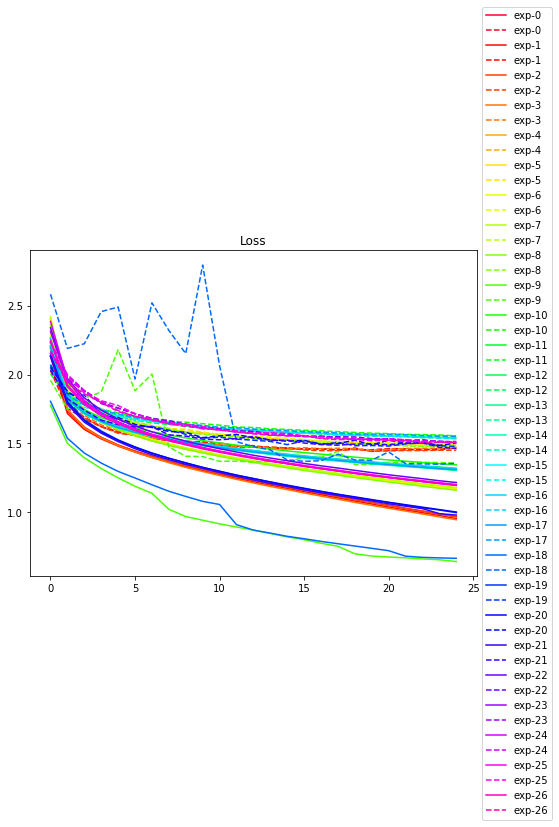

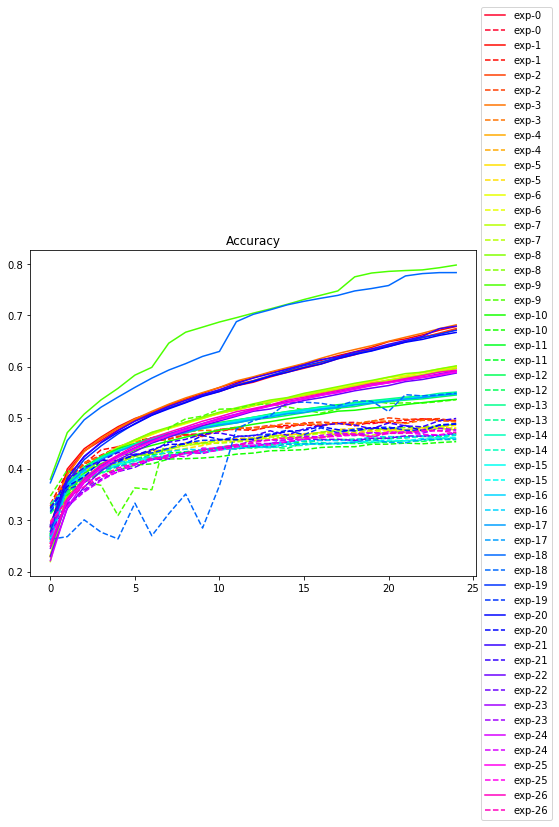

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()